## Predicting Bank Marketing using Machine Learning
This notebook looks into using various python-based machine learning and data science librariesin an attempt
to build a machine learning model capable of predicting bank marketing deposit based on their attributes. 
We are going to take the following approach:

* problem Defination
* Data
* Evaluation
* Features
* Modelling
* Experiments

## 1. Problem Defination
in a statement,
> given clinical parameters about a customer. can we predict whether or not they will subscribe deposit or not?

## 2. Data
The orignal data came from uci machine learning repository
There is a version available at kaggle also

## 3. Evaluation
> if we reach 95% accuracy at predicting whether or not customer will subscribe deposit during the proof of concepts.we'll persue the project.

## 4. Features
1 - age (numeric)
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services") 
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
   4 - education (categorical: "unknown","secondary","primary","tertiary")
   5 - default: has credit in default? (binary: "yes","no")
   6 - balance: average yearly balance, in euros (numeric) 
   7 - housing: has housing loan? (binary: "yes","no")
   8 - loan: has personal loan? (binary: "yes","no")
   # related with the last contact of the current campaign:
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 
  10 - day: last contact day of the month (numeric)
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
  12 - duration: last contact duration, in seconds (numeric)
   # other attributes:
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
  15 - previous: number of contacts performed before this campaign and for this client (numeric)
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  Output variable (desired target):
  17 - y - has the client subscribed a term deposit? (binary: "yes","no")

## Preparing tools

In [1]:
#importing all the thing we need

#Regular Exploratory Data Analysis tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#we want to apear plot in this notebook
%matplotlib inline

#models from scikit learn
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import RBFSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

#Model Evaluation 
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn.metrics import RocCurveDisplay 

## Load Data

In [2]:
df = pd.read_csv("bank.csv")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [3]:
df.deposit.value_counts()

deposit
no     5873
yes    5289
Name: count, dtype: int64

## Data Exploration (EDA or exploratory data analysis)

In [4]:
##lets find out of how many of each classes there
df["deposit"].value_counts()

deposit
no     5873
yes    5289
Name: count, dtype: int64

<Axes: xlabel='deposit'>

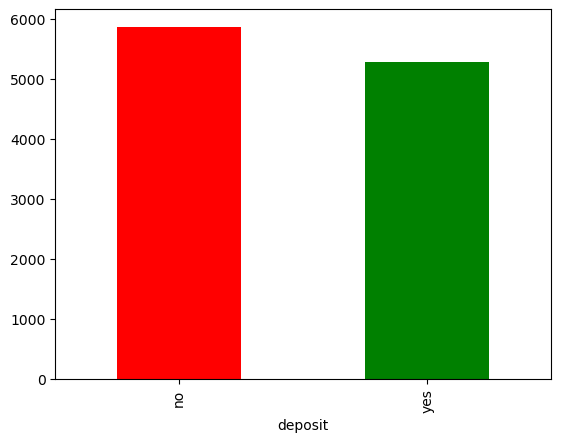

In [5]:
df["deposit"].value_counts().plot(kind="bar",color=["red","green"])

In [6]:
#Checking the null values in the dataset
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

In [7]:
#compare marital column with deposit column
pd.crosstab(df["marital"],df["deposit"])

deposit,no,yes
marital,,
divorced,671,622
married,3596,2755
single,1606,1912


Text(0, 0.5, 'amount')

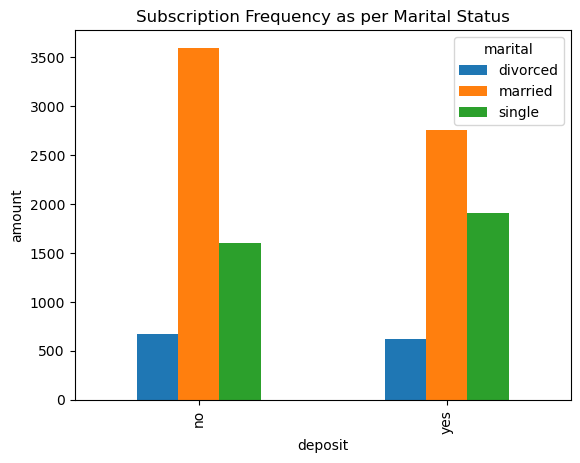

In [8]:
pd.crosstab(df["marital"],df["deposit"]).T.plot(kind="bar");
plt.title("Subscription Frequency as per Marital Status")
plt.ylabel("amount")

In [9]:
#compare job column with deposit column
pd.crosstab(df["job"],df["deposit"])

deposit,no,yes
job,,
admin.,703,631
blue-collar,1236,708
entrepreneur,205,123
housemaid,165,109
management,1265,1301
retired,262,516
self-employed,218,187
services,554,369
student,91,269


Text(0, 0.5, 'amount')

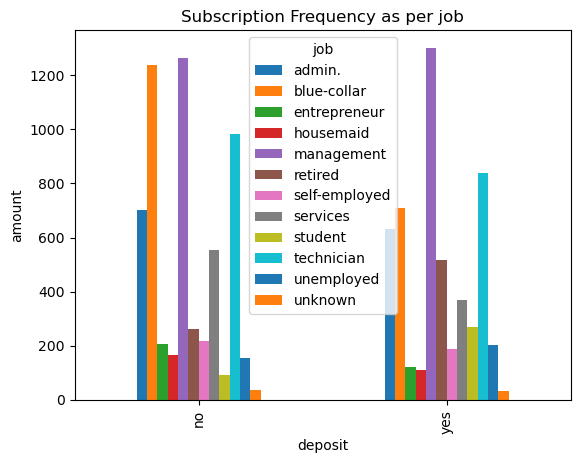

In [10]:
pd.crosstab(df["job"],df["deposit"]).T.plot(kind="bar");
plt.title("Subscription Frequency as per job")
plt.ylabel("amount")

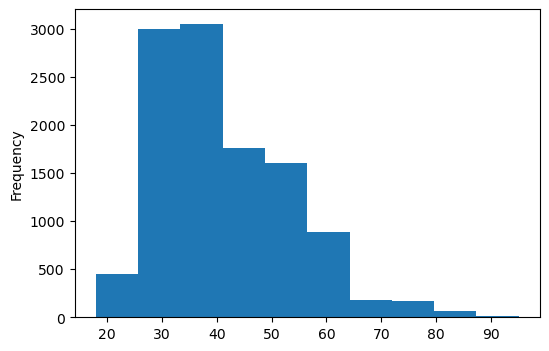

In [11]:
plt.figure(figsize=(6,4))
#check the distribution of the age column with histogtram
df.age.plot.hist();

In [12]:
df["education"].value_counts()

education
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: count, dtype: int64

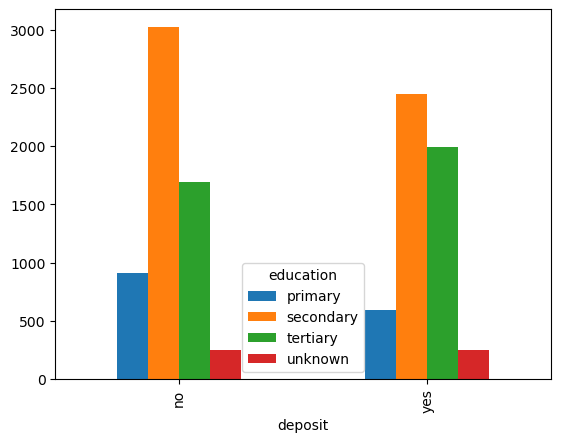

In [13]:
pd.crosstab(df["education"],df["deposit"]).T.plot(kind="bar");

Text(0, 0.5, 'Passed Days')

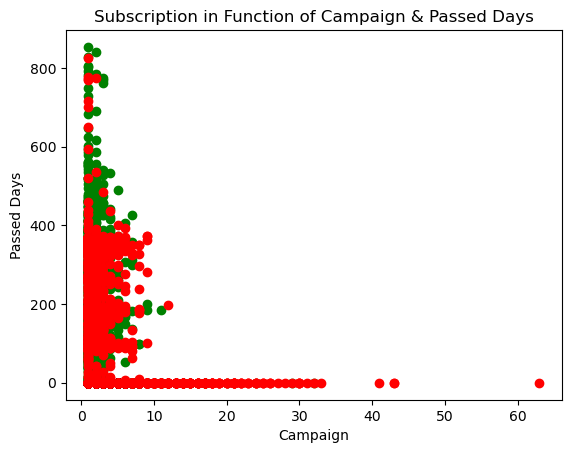

In [14]:
#scatter with positive example
plt.scatter(df.campaign[df.deposit=="yes"],df.pdays[df.deposit=="yes"],color="green");

#scatter with negative example
plt.scatter(df.campaign[df.deposit=="no"],df.pdays[df.deposit=="no"],color="red");

plt.title("Subscription in Function of Campaign & Passed Days")
plt.xlabel("Campaign")
plt.ylabel("Passed Days")


## Modeling

In [15]:
#split data into X and y
X = df.drop("deposit",axis=1)
y = df["deposit"]

In [16]:
#turn the categories into numbers 
from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer  
categorical_features = ["job","marital","education","default","housing","loan","contact","month","pdays","poutcome"] 
one_hot= OneHotEncoder()  
transformer = ColumnTransformer([("one_hot",one_hot,categorical_features)],remainder="passthrough")  
transformed_x= transformer.fit_transform(X) 
transformed_x

<11162x522 sparse matrix of type '<class 'numpy.float64'>'
	with 169494 stored elements in Compressed Sparse Row format>

In [17]:
df['deposit'] = df['deposit'].map({'yes': 1, 'no': 0})

In [18]:
y.head()

0    yes
1    yes
2    yes
3    yes
4    yes
Name: deposit, dtype: object

In [19]:
y.tail()

11157    no
11158    no
11159    no
11160    no
11161    no
Name: deposit, dtype: object

In [20]:
#setup random seed
np.random.seed(42)

#split data into train and test splits
x_train,x_test,y_train,y_test = train_test_split(transformed_x,y,test_size=0.2)

In [21]:
#put models in dictionary
models = {"SGD Classifer":SGDClassifier(),
         "Random Forest Classifier":RandomForestClassifier(),
         "KNeighbors Classifer":KNeighborsClassifier()
         }

#Create Function to fit and score models
def fit_and_score(models,x_train,x_test,y_train,y_test):
    #setup random seed
    np.random.seed(42)
    
    #create a dictionary of model scores
    model_scores = {}
    
    for name,model in models.items():
        
        #fit the models to the training data
        model.fit(x_train,y_train)
        
        #Evaluate scores to the test data
        model_scores[name]=model.score(x_test,y_test)

    return model_scores
        

In [22]:
model_scores = fit_and_score(models=models,x_train=x_train,x_test=x_test,y_train=y_train,y_test=y_test)
model_scores

{'SGD Classifer': 0.6762203313927452,
 'Random Forest Classifier': 0.8248992386923422,
 'KNeighbors Classifer': 0.7151813703537842}

## Comparison

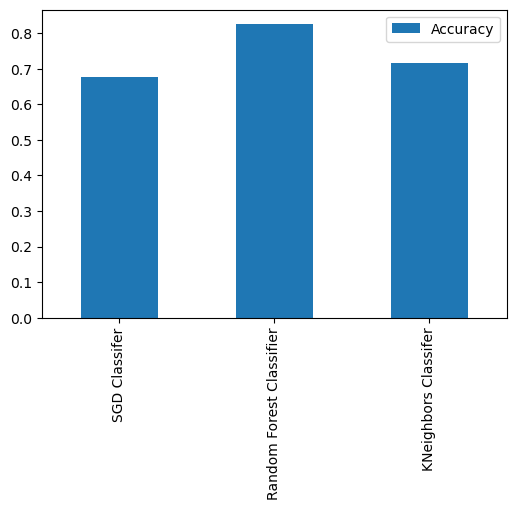

In [23]:
model_comparison = pd.DataFrame(model_scores,index=["Accuracy"])
model_comparison.T.plot(kind="bar",figsize=(6,4));

#Now we have got baseline models & we know a models first prediction arenot always what we should based our next steps? what should we do 
* Hyperparameters Tuning 
* Features Importance
* Confusion matrix
* Cross-Validation
* Precision
* Recall
* F1 Score
* Classification Report
* ROC Curve
* Area under the Curvea(AUC)

In [24]:
#Lets Tune KNN model
train_scores=[]
test_scores = []

#create a list of different values for n_neighbors
neighbors = range(1,25)

#setup model instance
knn = KNeighborsClassifier()

#loop through different n_neighbors
for i in neighbors:
    knn.set_params(n_neighbors=i)
    
    #fit the model
    knn.fit(x_train,y_train)
    
    #update the training scores list
    train_scores.append(knn.score(x_train,y_train))
    
     #update the test scores list
    test_scores.append(knn.score(x_test,y_test))
   

In [25]:
train_scores

[1.0,
 0.8283122410124314,
 0.8377197894501064,
 0.7928099451226341,
 0.7975137193414716,
 0.7783626385933475,
 0.7814984880725725,
 0.7694030686527047,
 0.7711949826408332,
 0.7634673535670288,
 0.7670511815432859,
 0.760779482584836,
 0.7624594019487064,
 0.7576436331056109,
 0.760891477209094,
 0.75484376749916,
 0.7592115578452234,
 0.7539478105050957,
 0.7557397244932244,
 0.7554037406204502,
 0.7550677567476761,
 0.7528278642625154,
 0.7524918803897412,
 0.7492440362862582]

In [26]:
test_scores

[0.6847290640394089,
 0.6623376623376623,
 0.7066726377071205,
 0.6977160770264218,
 0.7151813703537842,
 0.7075682937751904,
 0.7174205105239588,
 0.7115987460815048,
 0.7151813703537842,
 0.716524854455889,
 0.7227944469323779,
 0.7232422749664129,
 0.7232422749664129,
 0.7151813703537842,
 0.7214509628302732,
 0.7245857590685177,
 0.7227944469323779,
 0.7205553067622034,
 0.7277205553067622,
 0.7277205553067622,
 0.7272727272727273,
 0.7218987908643081,
 0.7254814151365876,
 0.7263770712046574]

Max score of KNN is 72.77%


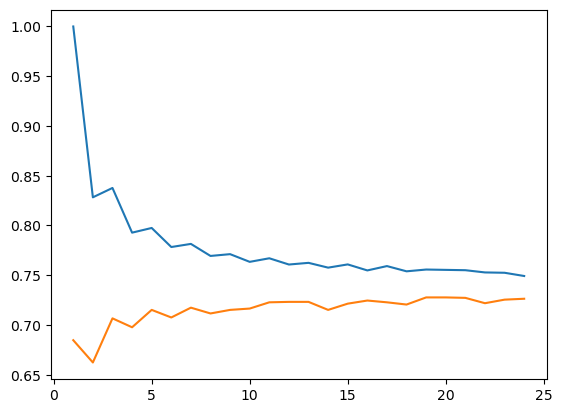

In [27]:
plt.plot(neighbors,train_scores,label="Train Scores")
plt.plot(neighbors,test_scores,label="Test Scores");
print(f"Max score of KNN is {max(test_scores)*100:.2f}%")

## Hyperparameters Tuning
We are going to tune:
* RandomforestClassifer()
* using GridSearchCv
* using RandomizedSearchCV


In [28]:
#create a grid of hyperparameters
rf_grid = {"n_estimators":[10,1000,50],
           "max_depth":[None, 5, 10, 15, 20],
           "min_samples_split": [2, 5, 10, 20],
           "max_features": ["sqrt", "log2", None]
          }


In [ ]:
#setup random seed
np.random.seed(42)

#setup GridSearchCV for RandomForestClassifer()
gs_rf = GridSearchCV(RandomForestClassifier(),param_grid=rf_grid,verbose=True)

#fit the model
gs_rf.fit(x_train,y_train)
print("print")
#Evaluate the model 
gs_rf.score(x_test,y_test)


Fitting 5 folds for each of 180 candidates, totalling 900 fits


In [ ]:
gs_rf.score(x_test,y_test)

In [ ]:
#setup random seed
np.random.seed(42)

#setup randomized search for logistic regression
rs_rf = RandomizedSearchCV(RandomForestClassifier(),param_distributions = rf_grid , cv=5,n_iter=20,verbose=True)

#fit randomSearch model for logistic regression
rs_rf.fit(x_train,y_train)

In [ ]:
rs_rf.score(x_test,y_test)